# **Preprocesamiento de imágenes**

El presente notebook tiene como objetivo el preprocesar las imágenes de ultrasonido antes de incorporarlas en el entrenamiento y evaluación de la inteligencia artificial.

## Resumen

Como ya se comentó en el archivo README.md, las imágenes de ultrasonido son en su totalidad capturas de pantallas del software donde se visualizan. Generalmente estas capturas de pantalla las generan los radiólogos para poder hacer apuntes o marcas que ayuden al diagnóstico por parte del médico. Si bien se podría hacer un uso completo de todas las imágenes, la información del software que se cuela en la captura de pantalla podría ser irrelevante en el entrenamiento y de momento no se tiene claro que tanto lo podría alterar, por lo cuál a través de OpenCV (cv2) se detectaron los bordes de la imagen para generar el recorte. 

Este procesamiento consta de **4** códigos
- **select_1.py**: Se encarga de tomar todas las imágenes de las que se dispone, hacer un primer filtrado a una carpeta 'selection' con 3 subcarpetas:
    ```
    selection
        con_info: Guarda las imágenes que si tienen diagnóstico
        no_apendice: Guarda las imágenes donde no es posible ver el apéndice
        no_paciente: No se poseen los datos necesarios para clasificar estas imágenes
    ```
    
- **crop_2.py**: Toma las imágenes de la subcarpetas 'con_info' y 'no_apendice', las recorta con identificación de bordes y los resultados los envía a las siguientes carpeta y subcarpetas:
    ```
    recortes 
        con_info: Guarda las imágenes recortadas que si tienen diágnóstico

    ordenadas
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
    ```

- **select_3.py**: Toma todas las imágenes de la carpeta 'recortes' y las organiza en la carpeta 'ordenadas'
    ```
    ordenadas
        apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue apendicitis
        no_apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue NO apendicitis
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
    ```

- **ia_data_4.py**: análisis de los resultados de las imágenes.
- **ia_data_5.py**: balanceo de las imágenes, normalización, reshape, vectorización y disposición de la info lista para utilizar en la ia.


Es importante resaltar que todos estos códigos tuvieron que correrse localmente, pues su uso en colab suele ser más lento, dificultando el proceso de desarrollo. Una vez creadas las carpetas (deben estar vacías) que deben ser muy parecidas a las estructuradas en este repositorio, se deben correr los código en el orden marcado para evitar problemas. 




# Metodología

## Primer filtrado

Son 2097 imágenes, pero se deben clasificar haciendo uso de los datos estructurados. 

### Carpetas:

Se encarga de tomar todas las imágenes de las que se dispone, hacer un primer filtrado a una carpeta 'selection' con 3 subcarpetas:

```
    selection
        con_info: Guarda las imágenes que si tienen diagnóstico
        no_apendice: Guarda las imágenes donde no es posible ver el apéndice
        no_paciente: No se poseen los datos necesarios para clasificar estas imágenes
```   
    

In [1]:
# select_1.py

'''
Con este código se pretenden seleccionar las imágenes que cuenten
con información suficiente para poder entrenar el modelo

El resultado de este código entrará al código 'crop.py'
para recortar cada una de las imágenes. 
'''

# Importar las librerías necesarias
import pandas as pd
import os
import re
import traceback
import shutil

# Ruta del archivo de la base de datos estructurada
file_path = r'structured_data\app_data.xlsx'

# Cargar la primera hoja del archivo Excel en un DataFrame
df = pd.read_excel(file_path, sheet_name=0)

# Columnas seleccionadas
seleccion = ['Appendix_on_US', 'US_Number', 'Diagnosis']

# Especificar las filas (todas) y columnas (seleccion) que se copiaran
df_filtered = df.loc[:, seleccion]


# Función para extraer el número del nombre del archivo con ayuda
# de las funciones regulares
def extract_number(filename):
    match = re.match(r"(\d+)", filename)
    return int(match.group(1)) if match else None


# Rutas de las carpetas de las imágenes originales y destino de los recortes
folder_path = r'us_images\originales' # Originales
con_info = r'us_images\selection\con_info' # Imágenes usables
no_apendice = r'us_images\selection\no_apendice' # Imágenes sin apéndice
no_paciente = r'us_images\selection\no_paciente' # Imágenes no usables

# Procesar cada archivo de imagen en la carpeta de entrada
for filename in os.listdir(folder_path):
    # Revisión que el archivo si corresponda a una imagen
    if filename.lower().endswith(('.png', '.bmp', '.jpeg', '.jpg', '.tif')):
        number = extract_number(filename) # número entero del archivo

        # Se busca en la base de datos filtrada si el número existe y se guardan
        # todos los valores de su fila
        fila_correspondiente = df_filtered.loc[df_filtered['US_Number'] == number]

        try:
            # Verifica que el número y la lista si existan
            if number is not None and fila_correspondiente.empty != True:

                # Revisa si el apendice aparece en la imagen
                if fila_correspondiente['Appendix_on_US'].iloc[0] == 'yes':

                    # Revisa si el diagnóstico es appendicitis o sin esta
                    if fila_correspondiente['Diagnosis'].iloc[0] == 'appendicitis' or\
                    fila_correspondiente['Diagnosis'].iloc[0] == 'no appendicitis':
                        target_folder = con_info

                    # Imágenes que no sirven en el entrenamiento
                    else:
                        target_folder = no_paciente
                
                # Imágenes donde no se ve el apéndice
                else: 
                    target_folder = no_apendice

            # Imágenes cuyos pacientes NO existen en la base de datos
            else:
                target_folder = no_paciente

            # Si no existe la carpeta target_folder, se crea
            if not os.path.exists(target_folder):
                os.makedirs(target_folder)

            # Determinar la carpeta de destino y mover el archivo    
            shutil.move(os.path.join(folder_path, filename),
                        os.path.join(target_folder, filename))

        except Exception as e:
            # Si hay un error, imprimirlo y continuar con la siguiente imagen
            print(f"No se pudo procesar el archivo: {filename}: {e}")
            traceback.print_exc() # Imprime el tipo de error

## Recorte

Aquí se hace uso de la identificación de bordes y se especifica que se descarten aquellos bordes menores a 250 pixeles y cuyo lado más  largo sea mayor a 1.5 veces el lado más corto. Esto evita que se recorten pequeños cuadros que hay en las capturas de pantalla.

### Carpetas:
Toma las imágenes de la subcarpetas 'con_info' y 'no_apendice', las recorta con identificación de bordes y los resultados los envía a las siguientes carpeta y subcarpetas:
    
```
    recortes 
        Guarda las imágenes recortadas que si tienen diágnóstico

    ordenadas
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
 ```


In [2]:
# crop.py

import cv2
import os

def ajustar_niveles(imagen, nivel_min, nivel_max):
    """
    Ajusta los niveles de la imagen utilizando cv2.normalize.
    """
    return cv2.normalize(imagen, None, alpha=nivel_min, beta=nivel_max, norm_type=cv2.NORM_MINMAX)

def encontrar_y_recortar_imagen(input_path, output_path):
    """
    Encuentra la imagen de ultrasonido dentro de una captura de pantalla y la recorta
    sin modificar el brillo y el contraste en la imagen recortada.
    """
    # Leer la imagen original
    imagen_original = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    
    # Ajustar los niveles de la imagen para mejorar el contraste
    imagen_contrastada = ajustar_niveles(imagen_gris, 0, 255)
    
    # Umbralizar la imagen para obtener una binarización
    _, imagen_binaria = cv2.threshold(imagen_contrastada, 1, 255, cv2.THRESH_BINARY)
    
    # Encontrar los contornos en la imagen binaria
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Procesar cada contorno encontrado
    for contorno in contornos:
        # Calcular el rectángulo delimitador para el contorno
        x, y, ancho, alto = cv2.boundingRect(contorno)
        borde_mas_corto = min(ancho, alto)
        borde_mas_largo = max(ancho, alto)
        proporcion = borde_mas_largo / borde_mas_corto

        # Comprobar si el contorno cumple con las condiciones de tamaño mínimo y proporción
        if borde_mas_corto >= 250 and proporcion <= 1.5:
            # Recortar la imagen original (sin ajustes de contraste) según el contorno que cumple con los requisitos
            imagen_recortada = imagen_original[y:y+alto, x:x+ancho]
            
            # Guardar la imagen recortada
            cv2.imwrite(output_path, imagen_recortada)
            break  # Terminar después de procesar el primer contorno válido

# Rutas de las carpetas de las imágenes originales y destino de los recortes
## Para LAs que tienen diagnóstico
input_folder1 = r'us_images\selection\con_info'
output_folder1 = r'us_images\recortes\con_info'

## Para las que no tienen apéndice en la imagen
input_folder2 = r'us_images\selection\no_apendice'
output_folder2 = r'us_images\ordenadas\no_apendice'

# Procesar cada archivo de imagen en la carpeta de entrada
def ubicar(input_folder, output_folder):
    '''
    Esta función permite a unas rutas dadas tomar las fotos que allí
    se encuentran, recortarlas y moverlas a otra ubicación
    '''
    if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

    not_image_files = 0
    unprocessed_files = 0      
    for filename in os.listdir(input_folder):
        try:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                input_path = os.path.join(input_folder, filename)
                base_name = os.path.splitext(filename)[0] + '.png'  # Cambiar la extensión a .png
                output_path = os.path.join(output_folder, base_name)
                
                # Intentar procesar la imagen
                try:
                    encontrar_y_recortar_imagen(input_path, output_path)
                except Exception as e:
                    print(f"No se pudo procesar el archivo {filename}: {e}")
                    unprocessed_files += 1
        except Exception as e:
            print(f"No se pudo procesar el archivo {filename}: {e}")
            not_image_files += 1
    print(f"Archivos que no son imágenes: {not_image_files} y archivos no procesados: {unprocessed_files}")

# Procesar imágenes con diagnóstico
ubicar(input_folder1, output_folder1)

# Procesar imágenes sin apendice
ubicar(input_folder2, output_folder2)


Archivos que no son imágenes: 0 y archivos no procesados: 0
No se pudo procesar el archivo 803.1 RLQ lymphadenitis mesenterialis_KLÄREN MIT ALYSSIA.bmp: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Archivos que no son imágenes: 0 y archivos no procesados: 1


## Ordenar
Hasta el momento solo se tienen ordenadas las imágenes donde el apendice no es visible, pero esto se resuelve con los siguientes códigos.

### Carpetas
Toma todas las imágenes de la carpeta 'recortes' y las organiza en la carpeta 'ordenadas'

```
    ordenadas
        apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue apendicitis
        no_apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue NO apendicitis
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
```

In [3]:
# select_3.py

import os # Para navegar por las carpetas de colab
import re # Para trabajar con expresiones regulares
import shutil # Para cambiar los archivos de ubicación
import traceback # Para usar con try except
import pandas as pd


# Ruta del archivo de la base de datos estructurada
file_path = r'structured_data\app_data.xlsx'

# Cargar la primera hoja del archivo Excel en un DataFrame
df = pd.read_excel(file_path, sheet_name=0)

# Columnas seleccionadas
seleccion = ['Appendix_on_US', 'US_Number', 'Diagnosis']

# Especificar las filas (todas) y columnas (seleccion) que se copiaran
df_filtered = df.loc[:, seleccion]


# Ruta a la carpeta donde están las imágenes sin ordenar
folder_path = r'us_images\recortes\con_info'

# Rutas a las carpetas donde se ordenarán las imágenes
apendicitis = r'us_images\ordenadas\apendicitis'
no_apendicitis = r'us_images\ordenadas\no_apendicitis'
no_apendice = r'us_images\ordenadas\no_apendice'
no_classification = r'us_images\ordenadas\no_classification'
no_id = r'us_images\ordenadas\no_id'

# Función para extraer el número del nombre del archivo con ayuda
# de las funciones regulares
def extract_number(filename):
    match = re.match(r"(\d+)", filename)
    return int(match.group(1)) if match else None

# Procesar cada archivo en la carpeta
count = 0 # Para poder almacenar los resultados en df_results
for filename in os.listdir(folder_path):
    # Revisión que el archivo si corresponda a una imagen
    if filename.lower().endswith(('.png', '.bmp', '.jpeg', '.jpg', '.tif')):
        number = extract_number(filename) # número entero del archivo

        # Se busca en la base de datos filtrada si el número existe y se guardan
        # todos los valores de su fila
        fila_correspondiente = df_filtered.loc[df_filtered['US_Number'] == number]

        try:

            # Revisa si el diagnóstico es appendicitis o sin esta
            if fila_correspondiente['Diagnosis'].iloc[0] == 'no appendicitis':
                target_folder = no_apendicitis

            else:
                target_folder = apendicitis

            if not os.path.exists(target_folder):
                os.makedirs(target_folder)

            # Determinar la carpeta de destino y mover el archivo
            shutil.move(os.path.join(folder_path, filename),
                        os.path.join(target_folder, filename))

        except Exception as e:
            # Si hay un error, imprimirlo y continuar con la siguiente imagen
            print(f"No se pudo procesar el archivo: {filename}: {e}")
            traceback.print_exc() # Imprime el tipo de error

Finalizando esta etapa, se procedió a revisar los resultados y limpiar manualmente un par de imágenes que parecían no ser importantes. 

## Procesamiento

De aquí en adelante lo que procura es generar una base de datos con las imágenes la cual pueda ser usada para el entrenamiento del modelo a desarrollar.

Este preprocesamiento de imágenes debe ir orientado al modelo que se piensa desarrollar y para ello es importante recordar que la propuesta de este trabajo es el uso de redes neuronales convolucionales, pero cuando se crea una red neuronal nueva todos sus parámetros inician de manera totalmente aleatoria y mediante el entrenamiento se ajustan gradualmente, el problema radica en que en este caso se cuenta únicamente con cientos de datos lo que dificulta este proceso y aumenta el riesgo de caer en sobreajuste.

Por lo anterior se buscará hacer un proceso de "transferencia de aprendizaje" es decir, tomar un modelo que sea bueno reconociendo imágenes de cualquier tipo y entrenarlo sobre este set. Se pretende usar [MobileNetV2](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5) donde se descartarían todas las salidas existentes del modelo (1001 clasificaciones), es decir, la útima capa, para remplazarla por otra con 3 clasificaciones ('sin apendice', 'apendicitis', 'no_apendicitis') y se entrenarían solo las últimas capas del modelo (sin tocar las otras), posteriormente se podrían entrenar todas las capas, pero con una tasa de aprendizaje muy baja. Esta entrega no pretende profundizar más sobre esa metodología, pero se deseaba que el lector comprendiese el camino a tomar en futuras entregas.

### Cuantificación
Antes del procesamiento de las imágenes, se debe generar una cuantificación de estas dependiendo su categoría con el fin de identificar desbalanceos. 

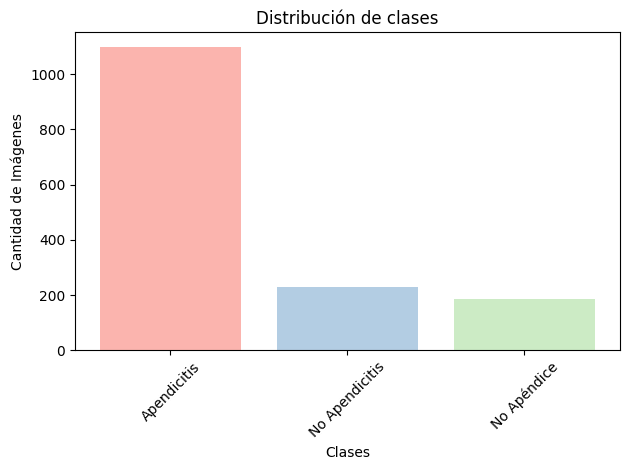


    Apendicitis: 1097, 
    No Apendicitis: 231,
    No Apéndice: 186



In [4]:
# ia_data_4.py

import pandas as pd
import os
import matplotlib.pyplot as plt

def copy_folder(folder):
    src = os.path.join('us_images', 'ordenadas', folder)
    dst = os.path.join('us_images', 'procesar', folder)
    
    if os.path.exists(src):
        shutil.copytree(src, dst)
    else:
        print(f"Folder {folder} does not exist in 'ordenadas'. Using it straight away.")

# Rutas de archivos
apendicitis = os.listdir(r'us_images\ordenadas\apendicitis')
copy_folder('apendicitis')
no_apendice = os.listdir(r'us_images\ordenadas\no_apendice')
copy_folder('no_apendice')
no_apendicitis = os.listdir(r'us_images\ordenadas\no_apendicitis')
copy_folder('no_apendicitis')

# Conteo de archivos en cada categoría
count = {
    'Apendicitis': len(apendicitis), 
    'No Apendicitis': len(no_apendicitis),
    'No Apéndice': len(no_apendice)
}

# Crear un DataFrame a partir del diccionario
df = pd.DataFrame(list(count.items()), columns=['Clase', 'Cantidad'])

# Colores pastel
colors = plt.cm.Pastel1.colors

# Crear un gráfico de barras
plt.bar(df['Clase'], df['Cantidad'], color = colors)
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de clases')
plt.xticks(rotation=45)  # Rotar las etiquetas si son demasiado largas
plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama
plt.show()

# Información para balancear
print(f'''
    Apendicitis: {len(apendicitis)}, 
    No Apendicitis: {len(no_apendicitis)},
    No Apéndice: {len(no_apendice)}
''')

El dataset está desbalanceado, por ende se opta por eliminar aleatoriamente instancias de la clase mayoritaria (Undersampling)

In [5]:
# ia_data_5.py

import os
import random
from shutil import copy2

# Ruta a la carpeta donde están tus imágenes de la clase 1
folder_path = r'us_images\procesar\apendicitis'

# Número deseado de muestras después del submuestreo
desired_samples = 1097

# Listar todos los archivos de imagen en la carpeta
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Seleccionar un subconjunto aleatorio de archivos
selected_files = random.sample(all_files, desired_samples)

# Eliminar los archivos que no han sido seleccionados si quieres que solo permanezcan los seleccionados en la carpeta original
for file_name in all_files:
    if file_name not in selected_files:
        os.remove(os.path.join(folder_path, file_name))

print(f'La cantidad de imágenes de la carpeta apendicitis es: {len(os.listdir(folder_path))}')

La cantidad de imágenes de la carpeta apendicitis es: 1097


Se repite el histograma para asegurar que se hayan balanceado las imágenes

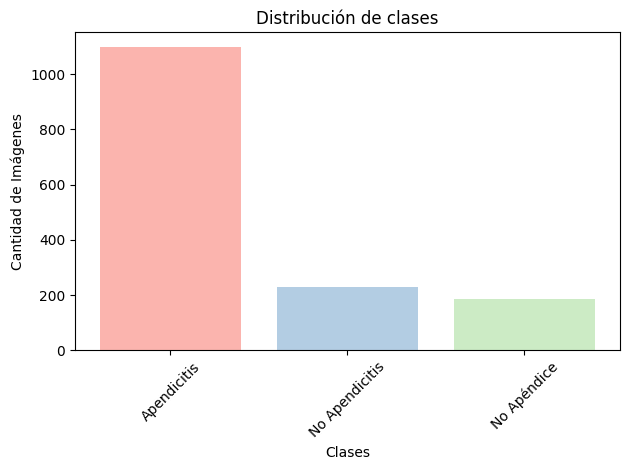


    Apendicitis: 1097, 
    No Apendicitis: 231,
    No Apéndice: 186



In [6]:
# ia_data_4.py

import pandas as pd
import os
import matplotlib.pyplot as plt

# Rutas de archivos
apendicitis = os.listdir(r'us_images\procesar\apendicitis')
no_apendice = os.listdir(r'us_images\procesar\no_apendice')
no_apendicitis = os.listdir(r'us_images\procesar\no_apendicitis')

# Conteo de archivos en cada categoría
count = {
    'Apendicitis': len(apendicitis), 
    'No Apendicitis': len(no_apendicitis),
    'No Apéndice': len(no_apendice)
}

# Crear un DataFrame a partir del diccionario
df = pd.DataFrame(list(count.items()), columns=['Clase', 'Cantidad'])

# Colores pastel
colors = plt.cm.Pastel1.colors

# Crear un gráfico de barras
plt.bar(df['Clase'], df['Cantidad'], color = colors)
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de clases')
plt.xticks(rotation=45)  # Rotar las etiquetas si son demasiado largas
plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama
plt.show()

# Información para balancear
print(f'''
    Apendicitis: {len(apendicitis)}, 
    No Apendicitis: {len(no_apendicitis)},
    No Apéndice: {len(no_apendice)}
''')

Es evidente que sigue habiendo un desbalanceo en los datos, pero es algo con lo que se puede trabajar. 

## Normalizacion de datos & separación en conjuntos Train y test

Para evitar que el modelo se aprenda las imágenes en el entrenamiento, generamos varios cambios como rotaciones, zoom, entre otros. 
Este proceso ayudará a que el modelo pueda reconocer las imagenes sin importar su rotación, algo importante puesto que el dataset no fue organizado debidamente y las impagenes no están marcadas como ecografías longitudinales o transversales.

Found 1212 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Classes in training set:  {'apendicitis': 0, 'no_apendice': 1, 'no_apendicitis': 2}
Classes in validation set:  {'apendicitis': 0, 'no_apendice': 1, 'no_apendicitis': 2}
Number of elements in each class in the training set:  {0: 878, 1: 149, 2: 185}
Number of elements in each class in the validation set:  {0: 219, 1: 37, 2: 46}


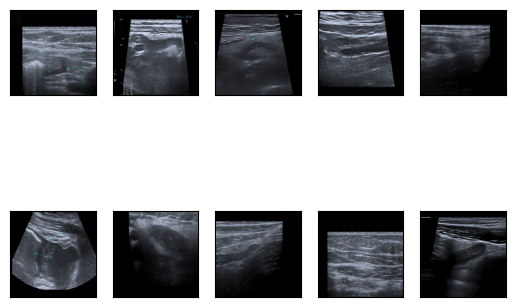

In [7]:
# Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Se instancia un objeto de la clase ImageDataGenerator, el cual aplicará 
# transformaciones en las imágenes para aumentar la variedad de datos.
datagen = ImageDataGenerator(
    rescale=1. / 255,  # Normalizar: Reescalar los valores de los píxeles para que estén entre 0 y 1
    #rotation_range = 30, # Rango de grados para rotaciones aleatorias de las imágenes.
    width_shift_range=0.25, # Rango (como fracción del total) para traslados horizontales aleatorios.
    height_shift_range=0.25, # Rango (como fracción del total) para traslados verticales aleatorios.
    #shear_range=15, # Intensidad de corte para aplicar cortes aleatorios en las imágenes.
    #zoom_range=[0.5, 1.5], # Rango para aplicar zoom aleatorio. 
    fill_mode="nearest",
    validation_split=0.2 # Porcentaje de los datos que se reservará para el conjunto de validación.
)

# Ubicación de las imágenes ordenadas
database = r'us_images\procesar'
img_size = 224

data_gen_entrenamiento = datagen.flow_from_directory(database, target_size=(img_size,img_size),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory(database, target_size=(img_size,img_size),
                                                     batch_size=32, shuffle=True, subset='validation')

# Print class indices
print("Classes in training set: ", data_gen_entrenamiento.class_indices)
print("Classes in validation set: ", data_gen_pruebas.class_indices)

# Count the number of elements in each class in the training set
unique, counts = np.unique(data_gen_entrenamiento.labels, return_counts=True)
print("Number of elements in each class in the training set: ", dict(zip(unique, counts)))

# Count the number of elements in each class in the validation set
unique, counts = np.unique(data_gen_pruebas.labels, return_counts=True)
print("Number of elements in each class in the validation set: ", dict(zip(unique, counts)))

# Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

# Inicia la Prueba de Modelos!

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(data_gen, model, valid_steps, ax):
    # Get the true labels
    y_true = data_gen.classes

    # Predict the values from the validation dataset
    Y_pred = model.predict(data_gen, valid_steps)
    # Convert predictions classes to one hot vectors 
    y_pred = np.argmax(Y_pred, axis=1)

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred) 

    # plot the confusion matrix
    sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

def plot_multiple_models(model_histories, data_gen_pruebas, valid_steps):
    num_models = len(model_histories)
    
    # Create a figure with 2 subplots for each model (one for training history, one for confusion matrix)
    fig, axs = plt.subplots(num_models, 2, figsize=(15, num_models*5))
    
    for i, (model_name, history) in enumerate(model_histories.items()):
        # Plot training history
        axs[i, 0].set_title(f'Training History for {model_name}')
        axs[i, 0].plot(history.history['accuracy'])
        axs[i, 0].plot(history.history['val_accuracy'])
        axs[i, 0].set_ylabel('Accuracy')
        axs[i, 0].set_xlabel('Epoch')
        axs[i, 0].legend(['Train', 'Validation'], loc='upper left')
        
        # Plot confusion matrix
        axs[i, 1].set_title(f'Confusion Matrix for {model_name}')
        plot_confusion_matrix(data_gen_pruebas, history.model, valid_steps, axs[i, 1])
        
    plt.tight_layout()
    plt.show()

In [9]:
# Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc

# Definir el modelo
def create_model_simpleCNN(size=150):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Ajusta la salida según tu problema
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Ajusta la configuración según sea necesario
    return model

# Definir el modelo
def create_model_scalingCNN(size=150):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Ajusta la salida según tu problema
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Ajusta la configuración según sea necesario
    return model

# Definir el modelo
def create_model_conventionalCNN(size=150):
    model = Sequential([
        Conv2D(300, (3, 3), activation='relu', input_shape=(size, size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(12, activation='relu'),
        Dense(3, activation='softmax')  # Ajusta la salida según tu problema
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Ajusta la configuración según sea necesario
    return model


In [10]:
simpleCNN = create_model_simpleCNN(img_size)

# Define the number of training and validation steps
train_steps = data_gen_entrenamiento.samples // data_gen_entrenamiento.batch_size
valid_steps = data_gen_pruebas.samples // data_gen_pruebas.batch_size

# Train the model
history_simpleCNN = simpleCNN.fit(
    data_gen_entrenamiento,
    steps_per_epoch=train_steps,
    validation_data=data_gen_pruebas,
    validation_steps=valid_steps,
    epochs=35  # replace with the number of epochs you want
)


C:\Users\escob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35


C:\Users\escob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 881ms/step - accuracy: 0.6074 - loss: 2.5497 - val_accuracy: 0.7222 - val_loss: 0.8047
Epoch 2/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.8901 - val_accuracy: 0.7857 - val_loss: 0.6996
Epoch 3/35


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 842ms/step - accuracy: 0.7094 - loss: 0.8485 - val_accuracy: 0.7292 - val_loss: 0.8490
Epoch 4/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.7174 - val_accuracy: 0.6429 - val_loss: 0.9231
Epoch 5/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 858ms/step - accuracy: 0.7238 - loss: 0.8309 - val_accuracy: 0.7292 - val_loss: 0.7830
Epoch 6/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 0.7788 - val_accuracy: 0.6429 - val_loss: 0.9908
Epoch 7/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 818ms/step - accuracy: 0.6846 - loss: 0.8867 - val_accuracy: 0.7292 - val_loss: 0.7720
Epoch 8/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.9704 - val_accuracy: 0.6429 - val_loss: 0.8812
Epoch 9/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 815ms/step - accuracy: 0.7264 - loss: 0.7906 - val_accuracy: 0.7153 - val_loss: 0.8074
Epoch 10/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.8631 - val_accuracy: 0.9286 - val_los

In [11]:
scalingCNN = create_model_scalingCNN(img_size)

# Define the number of training and validation steps
train_steps = data_gen_entrenamiento.samples // data_gen_entrenamiento.batch_size
valid_steps = data_gen_pruebas.samples // data_gen_pruebas.batch_size

# Train the model
history_scalingCNN = scalingCNN.fit(
    data_gen_entrenamiento,
    steps_per_epoch=train_steps,
    validation_data=data_gen_pruebas,
    validation_steps=valid_steps,
    epochs=35  # replace with the number of epochs you want
)

Epoch 1/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 897ms/step - accuracy: 0.6471 - loss: 1.0269 - val_accuracy: 0.7326 - val_loss: 0.7946
Epoch 2/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.8845 - val_accuracy: 0.5714 - val_loss: 0.9701
Epoch 3/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 879ms/step - accuracy: 0.7104 - loss: 0.8549 - val_accuracy: 0.7292 - val_loss: 0.7687
Epoch 4/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.7717 - val_accuracy: 0.6429 - val_loss: 0.9433
Epoch 5/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 858ms/step - accuracy: 0.7294 - loss: 0.8000 - val_accuracy: 0.7222 - val_loss: 0.7968
Epoch 6/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.8196 - val_accuracy: 0.7857 - val_loss: 0.7082
Epoch 7/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 841ms/step - accuracy: 0.7310 - loss: 0.8167 - val_accuracy: 0.7188 - val_loss: 0.7931
Epoch 8/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.7468 - val_accuracy: 0.8571

In [12]:
conventionalCNN = create_model_conventionalCNN(img_size)

# Define the number of training and validation steps
train_steps = data_gen_entrenamiento.samples // data_gen_entrenamiento.batch_size
valid_steps = data_gen_pruebas.samples // data_gen_pruebas.batch_size

# Train the model
history_conventionalCNN = conventionalCNN.fit(
    data_gen_entrenamiento,
    steps_per_epoch=train_steps,
    validation_data=data_gen_pruebas,
    validation_steps=valid_steps,
    epochs=35  # replace with the number of epochs you want
)

Epoch 1/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 252s 7s/step - accuracy: 0.6470 - loss: 0.9032 - val_accuracy: 0.7257 - val_loss: 0.8038
Epoch 2/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9062 - loss: 0.5883 - val_accuracy: 0.7143 - val_loss: 0.7821
Epoch 3/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.7298 - loss: 0.7870 - val_accuracy: 0.7326 - val_loss: 0.7696
Epoch 4/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7500 - loss: 0.7579 - val_accuracy: 0.5714 - val_loss: 1.0516
Epoch 5/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy: 0.7257 - loss: 0.7921 - val_accuracy: 0.7222 - val_loss: 0.7843
Epoch 6/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7500 - loss: 0.7516 - val_accuracy: 0.7857 - val_loss: 0.7131
Epoch 7/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.7287 - loss: 0.7816 - val_accuracy: 0.7326 - val_loss: 0.7651
Epoch 8/35
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7500 - loss: 0.7289 - val_accuracy: 0.5714 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


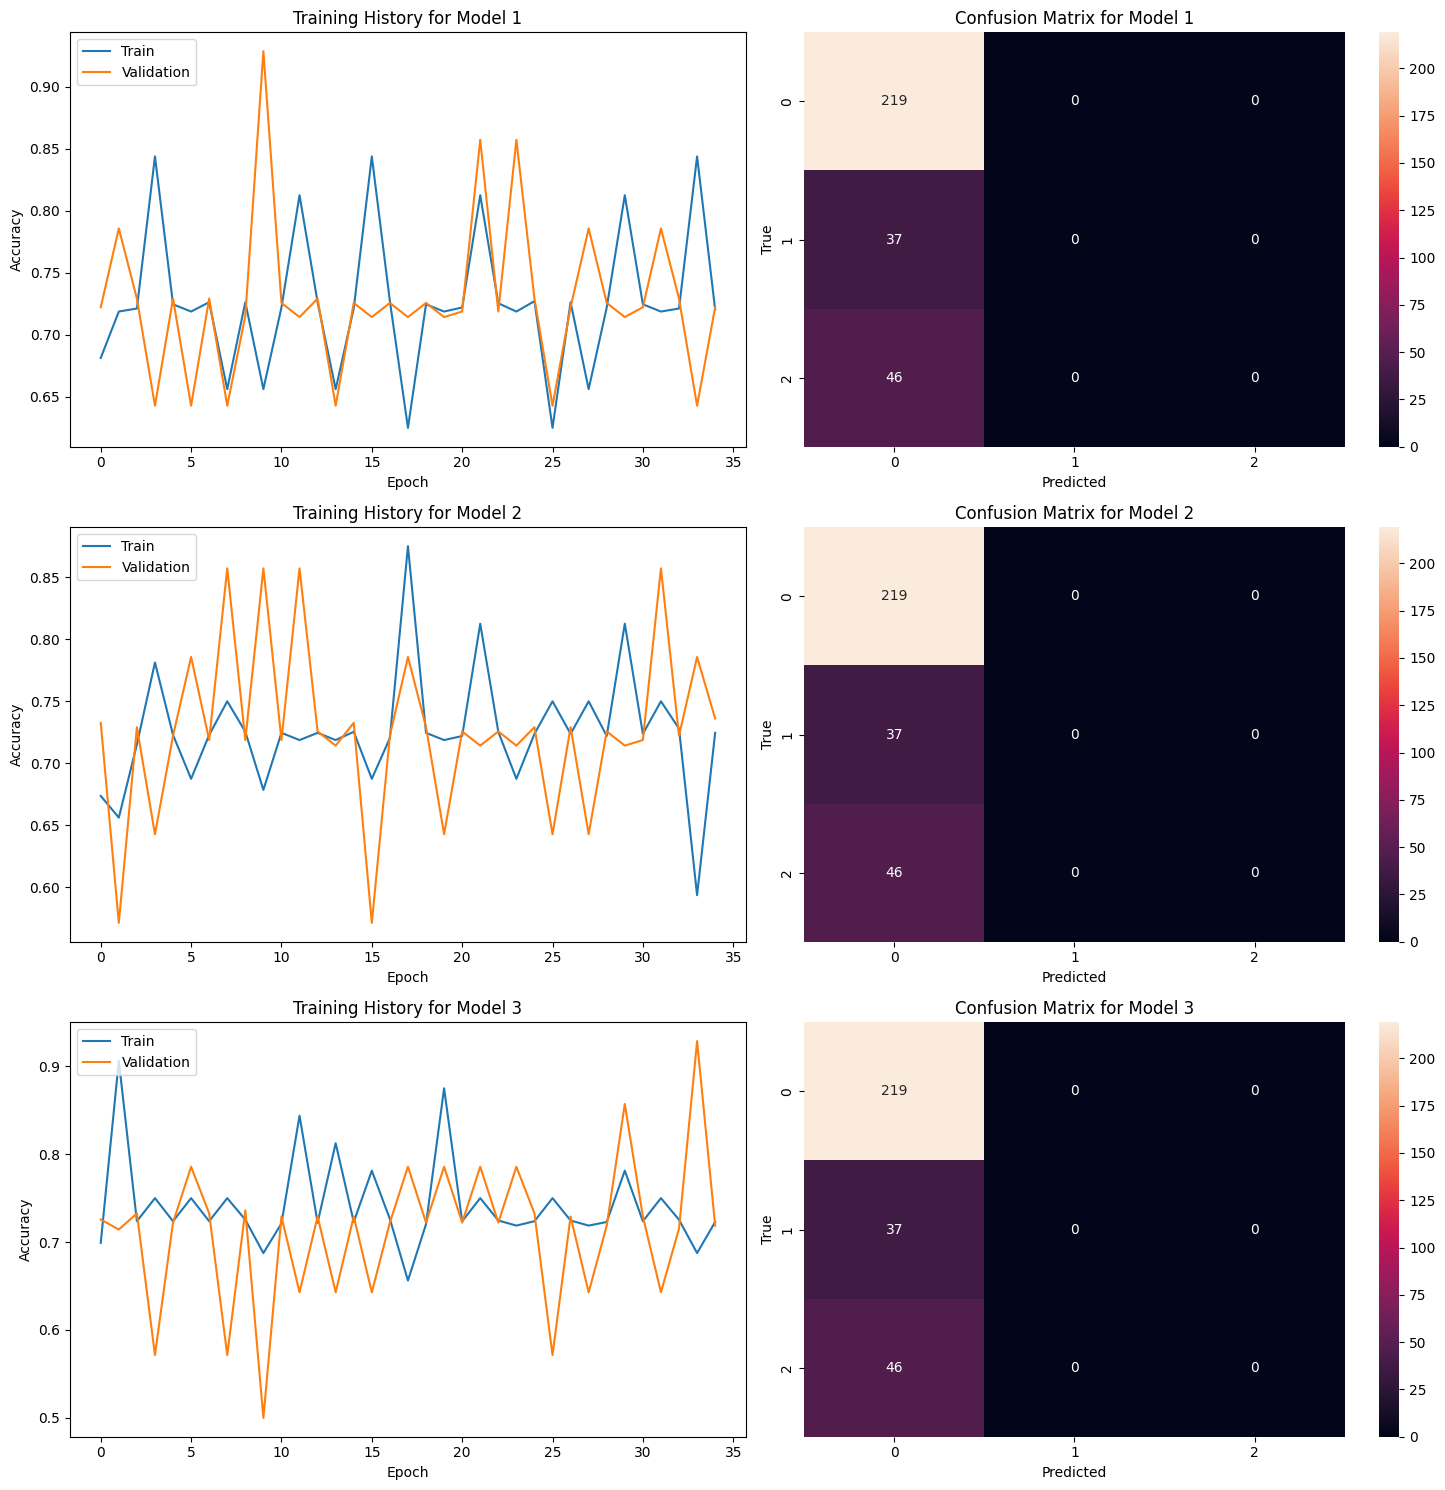

In [13]:
#plot_training_history(history_simpleCNN)
#plot_confusion_matrix(data_gen_pruebas, simpleCNN, valid_steps)

# Put the histories in a dictionary with the model names as keys
model_histories = {
    'Model 1': history_simpleCNN,
    'Model 2': history_scalingCNN,
    'Model 3': history_conventionalCNN
}

# Use the function to plot the training history and confusion matrix for each model
plot_multiple_models(model_histories, data_gen_pruebas, valid_steps)

# MobileNetv2

In [14]:
#Aquí se muestra cómo usar MobileNetV2 en TensorFlow:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [15]:
num_classes = len(data_gen_entrenamiento.class_indices)

# Definir el modelo
modelSimpleCNNv2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Definir el optimizador con una tasa de aprendizaje más baja
opt = Adam(learning_rate=0.0001)

# Compilar el modelo con el nuevo optimizador
modelSimpleCNNv2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con el nuevo optimizador
history_modelSimpleCNNv2 = modelSimpleCNNv2.fit(data_gen_entrenamiento, epochs=50, steps_per_epoch=len(data_gen_entrenamiento), verbose=1, validation_data=data_gen_pruebas, validation_steps=valid_steps)

C:\Users\escob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 909ms/step - accuracy: 0.6871 - loss: 0.8942 - val_accuracy: 0.7257 - val_loss: 0.8217
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7143 - val_loss: 0.7246


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 863ms/step - accuracy: 0.7145 - loss: 0.8495 - val_accuracy: 0.7222 - val_loss: 0.8218
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7857 - val_loss: 0.6655
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 869ms/step - accuracy: 0.7070 - loss: 0.8483 - val_accuracy: 0.7292 - val_loss: 0.7936
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6429 - val_loss: 0.9038
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 902ms/step - accuracy: 0.7304 - loss: 0.7850 - val_accuracy: 0.7326 - val_loss: 0.7602
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 1.0791
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 875ms/step - accuracy: 0.7223 - loss: 0.8104 - val_accuracy: 0.7326 - val_loss: 0.7741
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model

# Cargar MobileNetV2 sin las capas densas (solo las capas convolucionales)
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Visualizar la arquitectura del modelo
plot_model(base_model, to_file='mobilenetv2.png', show_shapes=True, show_layer_names=True)

C:\Users\escob\AppData\Local\Temp\ipykernel_31184\2477754010.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [17]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Crear el modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(data_gen_entrenamiento.class_indices), activation='softmax')(x)

mobileNetv2_1 = Model(inputs=base_model.input, outputs=predictions)

""" # Congelar todas las capas de MobileNetV2
for layer in base_model.layers:
    layer.trainable = False """

# Entrenar el modelo
# Set the learning rate
lr = 0.0001
opt = Adam(learning_rate=lr) # Instantiate the optimizer

# Unfreeze the base MobileNet model
base_model.trainable = True 
# Fine-tune from this layer onwards
fine_tune_at = 130
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compilar el modelo
mobileNetv2_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set the early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history_mobileNetv2_1 = mobileNetv2_1.fit(data_gen_entrenamiento, epochs=300, validation_data=data_gen_pruebas, validation_steps=valid_steps, callbacks=[reduce_lr, early_stop])

C:\Users\escob\AppData\Local\Temp\ipykernel_31184\4078466185.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6509 - loss: 0.9427 - val_accuracy: 0.7257 - val_loss: 0.7993 - learning_rate: 1.0000e-04
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 827ms/step - accuracy: 0.7420 - loss: 0.6915 - val_accuracy: 0.6429 - val_loss: 0.8660 - learning_rate: 1.0000e-04
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7325 - loss: 0.6603 - val_accuracy: 0.7222 - val_loss: 0.8630 - learning_rate: 1.0000e-04
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 839ms/step - accuracy: 0.7608 - loss: 0.5957 - val_accuracy: 0.7857 - val_loss: 0.7901 - learning_rate: 1.0000e-04
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7751 - loss: 0.5695 - val_accuracy: 0.7222 - val_loss: 1.0005 - learning_rate: 1.0000e-04
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 773ms/step - accuracy: 0.7767 - loss: 0.5356 - val_accuracy: 0.7857 - val_loss: 0.9780 - learning_rate: 1.0000e-04
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 941ms/step - accur

In [18]:
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Añadir Dropout para evitar el sobreajuste
predictions = Dense(len(data_gen_entrenamiento.class_indices), activation='softmax')(x)

efficientNet_model = Model(inputs=base_model.input, outputs=predictions)

# Ajustar las capas congeladas y el optimizador
lr = 0.0001
opt = Adam(learning_rate=lr)  # Instanciar el optimizador

# Descongelar el modelo base de EfficientNetB0
base_model.trainable = True
fine_tune_at = 100  # Ajustar el punto de fine-tuning

# Congelar todas las capas antes de fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar el modelo
efficientNet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar EarlyStopping y ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Entrenar el modelo
history_efficientNet = efficientNet_model.fit(
    data_gen_entrenamiento,
    epochs=300,
    validation_data=data_gen_pruebas,
    validation_steps=valid_steps,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6810 - loss: 0.8670 - val_accuracy: 0.1285 - val_loss: 1.2561 - learning_rate: 1.0000e-04
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7078 - loss: 0.8353 - val_accuracy: 0.0000e+00 - val_loss: 1.1771 - learning_rate: 1.0000e-04
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7139 - loss: 0.8189 - val_accuracy: 0.7188 - val_loss: 1.0368 - learning_rate: 1.0000e-04
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7347 - loss: 0.7903 - val_accuracy: 0.8571 - val_loss: 0.9094 - learning_rate: 1.0000e-04
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7033 - loss: 0.8539 - val_accuracy: 0.7188 - val_loss: 0.9561 - learning_rate: 1.0000e-04
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7531 - loss: 0.7619 - val_accuracy: 0.8571 - val_loss: 0.8803 - learning_rate: 1.0000e-04
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.

In [19]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from keras.utils import to_categorical

def compare_model_metrics(models, dataGenerator):
    metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'ROC AUC']
    
    # Get the true labels
    y_true = dataGenerator.classes
    y_true = to_categorical(y_true, num_classes=len(dataGenerator.class_indices))  # convert to one-hot encoding
    
    results = []
    
    for model in models:
        # Predict the values from the test dataset
        Y_pred = model.predict(dataGenerator)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, np.round(Y_pred))
        sensitivity = recall_score(y_true, np.round(Y_pred), average='macro')
        specificity = recall_score(y_true, 1-np.round(Y_pred), average='macro')  # specificity is recall of the negative class
        roc_auc = roc_auc_score(y_true, Y_pred, average='macro', multi_class='ovo')
        
        results.append([accuracy, sensitivity, specificity, roc_auc])
    
    print("Model Comparison Metrics:")
    print("{:<15} {:<15} {:<15} {:<15} {:<15}".format("Model", *metrics))
    
    for i, model in enumerate(models):
        print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(f"Model {i+1}", *results[i]))


In [20]:
# Comparar los modelos
compare_model_metrics([simpleCNN, scalingCNN, conventionalCNN, modelSimpleCNNv2, mobileNetv2_1, efficientNet_model], data_gen_pruebas)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 786ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
Model Comparison Metrics:
Model           Accuracy        Sensitivity     Specificity     ROC AUC        
Model 1         0.7252          0.3333          0.6667          0.5242         
Model 2         0.7252          0.3333          0.6667          0.5317         
Model 3         0.7252          0.3333          0.6667          0.5103         
Model 4         0.7252          0.3333          0.6667          0.4762         
Model 5         0.6358          0.3037          0.6963          0.5184         
Model 6         0.7252          0.3333          0.6667          0.5284         


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 802ms/step


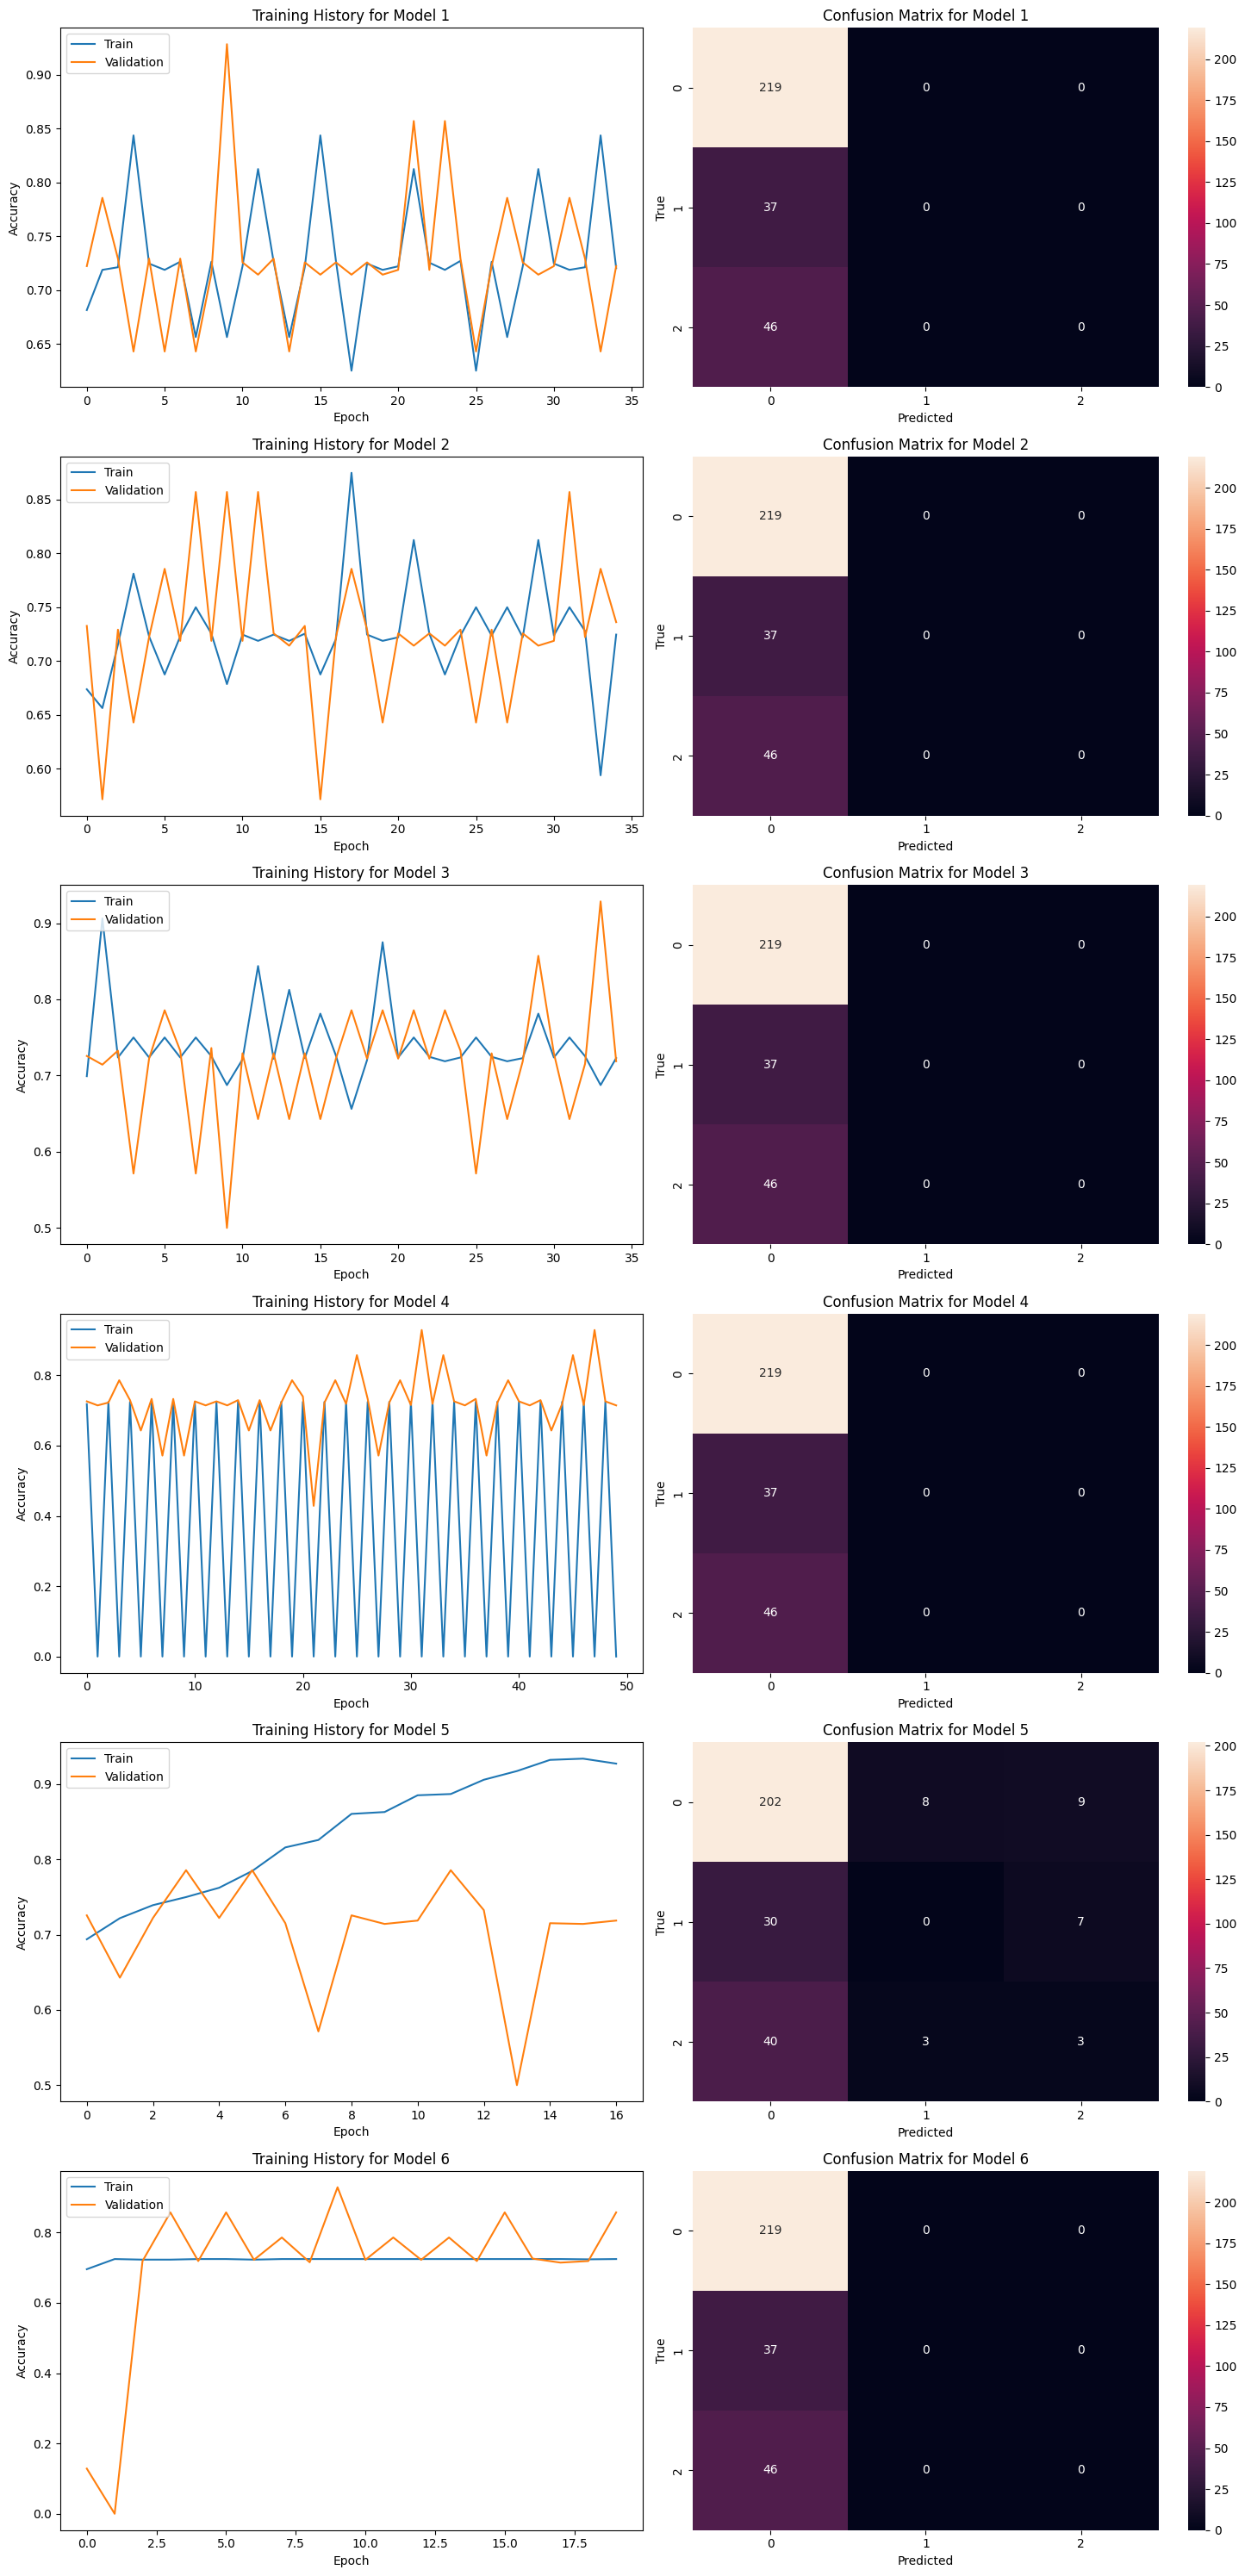

In [21]:

# Put the histories in a dictionary with the model names as keys
model_histories = {
    'Model 1': history_simpleCNN,
    'Model 2': history_scalingCNN,
    'Model 3': history_conventionalCNN,
    'Model 4': history_modelSimpleCNNv2,
    'Model 5': history_mobileNetv2_1,
    'Model 6': history_efficientNet
}

# Use the function to plot the training history and confusion matrix for each model
plot_multiple_models(model_histories, data_gen_pruebas, valid_steps)

## Kfolds Crossvalidation

Finalmente nuestro set de entrenamiento y prueba está listo!

In [22]:
##  PRUEBA KFOLDS
# Configurar KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Ubicación de las imágenes ordenadas
database = r'us_images\procesar'

# Configurar ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=15,
    zoom_range=[0.5, 1.5]
)

data_gen = datagen.flow_from_directory(database, target_size=(150, 150),
                                       batch_size=4, shuffle=True)

# Obtener todas las imágenes y etiquetas
images, labels = [], []
for image, label in data_gen:
    images.append(image)
    labels.append(label)
    if len(images) * 8 >= data_gen.samples:  # Usar el nuevo tamaño del lote
        break

images = np.concatenate(images)
labels = np.concatenate(labels)

# Almacenar las métricas
history_dicts = []
aucs = []

for train_index, val_index in kfold.split(images):
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Limitar el número de pasos de entrenamiento por época
    total_steps = len(X_train) // 8  # Tamaño del lote de 16

    model = create_model_simpleCNN()
    history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val),
                        steps_per_epoch=total_steps)  # Limitar el número de pasos de entrenamiento por época

    history_dicts.append(history.history)

    

Found 1514 images belonging to 3 classes.


C:\Users\escob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/76 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.6656 - loss: 1.0282

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.6742 - loss: 0.9646 - val_accuracy: 0.7039 - val_loss: 0.8112
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.7308 - loss: 0.7676 - val_accuracy: 0.7039 - val_loss: 0.8234
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.7269 - loss: 0.7258 - val_accuracy: 0.7039 - val_loss: 0.8314
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.7487 - loss: 0.6174 - val_accuracy: 0.6974 - val_loss: 0.9018
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.7940 - loss: 0.4650 - val_accuracy: 0.6908 - val_loss: 1.0228
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.8688 - loss: 0.3124 - val_accuracy: 0.6974 - val_loss: 1.2195
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.8981 - loss: 0.2381 - val_accuracy: 0.6711 - val_loss: 1.2763
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9465 - loss: 0.1237 - val_accuracy: 0.6974 - val

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       114
           1       0.27      0.14      0.18        22
           2       0.18      0.12      0.15        16

    accuracy                           0.70       152
   macro avg       0.41      0.38      0.39       152
weighted avg       0.64      0.70      0.66       152



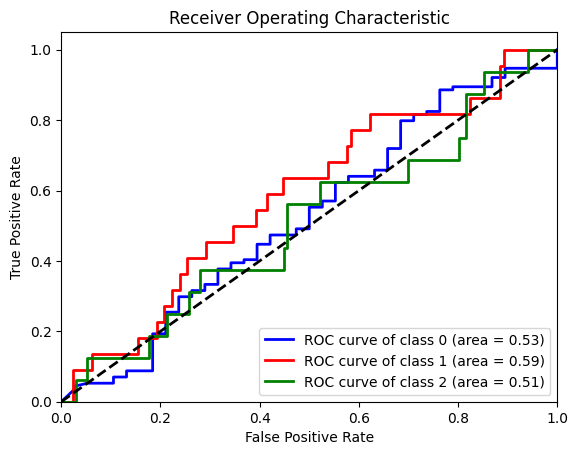

In [23]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize

# Predicciones de validación
y_val_pred = model.predict(X_val)

# Convertir las etiquetas y las predicciones al formato de clase única
y_val_single = np.argmax(y_val, axis=1)
y_val_pred_single = np.argmax(y_val_pred, axis=1)

# Imprimir el reporte de clasificación
print(classification_report(y_val_single, y_val_pred_single))

# Convertir las etiquetas al formato binario
y_val_binary = label_binarize(y_val_single, classes=np.unique(y_val_single))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_val_single))):
    fpr[i], tpr[i], _ = roc_curve(y_val_binary[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el promedio de los AUCs
mean_auc = np.mean(list(roc_auc.values()))

# Graficar la curva ROC para cada clase
plt.figure()
colors = ['blue', 'red', 'green']  # Puedes ajustar los colores según la cantidad de clases
for i, color in zip(range(len(np.unique(y_val_single))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()